<a href="https://colab.research.google.com/github/alicmu2024/GNSS-Jamming-Detection-and-Classification-using-Machine-Learning-Deep-Learning-and-Computer-Vision/blob/main/Jamming_Detection_Better_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **`In The Name of The 1st Pogrammer in The World!`**

1. read about resnet18 model
2. read about transfer learning in computer vision
3. take a closer look at the dataset split(bettre splitting, balancing and relevant details, logics , etc.)

In [ ]:
# Downloading The Dataset
%%capture
! wget https://zenodo.org/records/3783969/files/Jamming_Classifier.zip?download=1

In [ ]:
%%capture
%cp /content/Jamming_Classifier.zip?download=1 Jamming_Classifier.zip
! rm -rf /content/Jamming_Classifier.zip?download=1
! unzip ./Jamming_Classifier.zip
! rm -rf /content/energyop.m
! rm -rf /content/Channel
! rm -rf /content/Classifier
! rm -rf /content/Detector_Functions
! rm -rf /content/GNSS_signals
! rm -rf /content/Init
! rm -rf /content/Jammer_signals
! rm -rf /content/Misc
! rm -rf /content/Plotting
! rm -rf /content/Progress_Bar
! rm -rf /content/Sim
! rm -rf /content/Test_statistic
! rm -rf /content/CNN_algorithm.m
! rm -rf /content/Jamming_Classifier.zip
! rm -rf /content/SVM_algorithm.m
! rm -rf /content/SVM_algorithm2.m
! rm -rf /content/Testing_CNR_JSR.mat
! rm -rf /content/Training_CNR_JSR.mat
! rm -rf /content/energyop.m
! rm -rf /content/main.m
! rm -rf /content/main_test_classifiers.m
! rm -rf /content/parfor_progress_percentage.txt
! rm -rf /content/plotConfMat.m
! rm -rf /content/stopIfAccuracyNotImproving.m

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np

import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
data_dir = '.'
data_dir = str(data_dir)

In [ ]:
classes = os.listdir(data_dir + "/Image_training_database")
print(classes)

['SingleAM', 'NB', 'SingleFM', 'DME', 'NoJam', 'SingleChirp']


In [ ]:
def show_images(dataset='train'):
    next_pix= []
    # Parameters for our graph; we'll output images in a 5x2 configuration
    nrows = 5
    ncols = 2

    fig = plt.gcf()
    fig.set_size_inches(ncols * 5, nrows * 5)
    for i in range(len(classes)):
        next_pix.append(os.path.join(data_dir,dataset,classes[i]))
        img = mpimg.imread(os.path.join(next_pix[i],random.choice(os.listdir(next_pix[i]))))
        # Set up subplot; subplot indices start at 1
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off') # Don't show axes (or gridlines)
        plt.imshow(img)
        plt.title(classes[i])

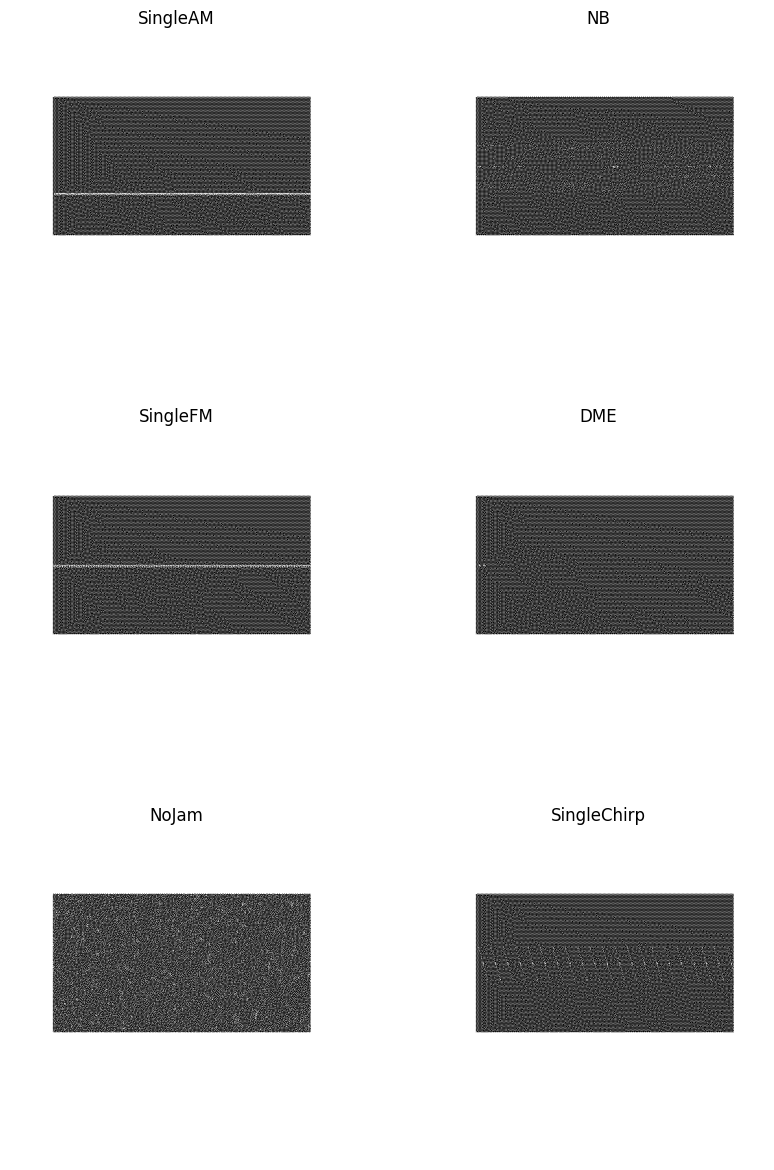

In [ ]:
# showing training images
show_images('./Image_training_database')

In [ ]:
from torch.utils.data import  random_split

train_dir = '/content/Image_training_database'
test_dir = '/content/Image_testing_database'
# Data transforms (normalization & data augmentation)
stats = ((0.7582, 0.7582, 0.7582), (0.4282, 0.4282, 0.4282))
train_tfms = tt.Compose([
    tt.Resize(128),
    tt.ToTensor(),
    tt.Normalize(*stats, inplace=True)])

valid_tfms = tt.Compose([
    tt.Resize(128),
    tt.ToTensor(),
    tt.Normalize(*stats)])

# PyTorch datasets
train_ds = ImageFolder(train_dir, train_tfms)
valid_ds = ImageFolder(test_dir, valid_tfms)

# Split validation dataset into validation and test datasets (50-50)
valid_size = len(valid_ds)
val_split = valid_size // 2  # Calculate the split size
test_split = valid_size - val_split  # Ensure all samples are used

valid_ds, test_ds = random_split(valid_ds, [val_split, test_split])

# PyTorch data loaders
batch_size = 32
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=2,
                      pin_memory=True)

valid_dl = DataLoader(valid_ds,
                      batch_size,
                      num_workers=2,
                      pin_memory=True)

test_dl = DataLoader(test_ds,
                     batch_size,
                     num_workers=2,
                     pin_memory=True)

# Now you have train_dl, valid_dl, and test_dl ready for use

In [ ]:
print('number of training samples  : ',len(train_dl) * batch_size)
print('number of validation samples: ', len(valid_dl) * batch_size)
print('number of testing samples   : ', len(test_dl) * batch_size)

number of training samples  :  60000
number of validation samples:  30016
number of testing samples   :  30016


We do not need ~30k images for testing and validating of the model.

Even 15k is more than enough!!!

# new #####

In [ ]:
import os
from collections import Counter
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import DataLoader, Subset

# Define your dataset directories
train_dir = '/content/Image_training_database'
test_dir = '/content/Image_testing_database'

# Data transforms (normalization & data augmentation)
stats = ((0.7582, 0.7582, 0.7582), (0.4282, 0.4282, 0.4282))
train_tfms = tt.Compose([
    tt.Resize(128),
    tt.ToTensor(),
    tt.Normalize(*stats, inplace=True)
])

valid_tfms = tt.Compose([
    tt.Resize(128),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

# Load the datasets
train_ds = ImageFolder(train_dir, train_tfms)
test_ds = ImageFolder(test_dir, valid_tfms)

# Combine the datasets
combined_ds = train_ds + test_ds

# Total number of images in the combined dataset
total_images = len(combined_ds)
print('Total number of images: ', total_images)

# Get the class labels
class_labels = [combined_ds[i][1] for i in range(total_images)]
class_counts = Counter(class_labels)
print("Class distribution in combined dataset:", class_counts)

# Stratified split
train_indices, temp_indices = train_test_split(
    list(range(total_images)),
    test_size=30000,
    stratify=class_labels,
    random_state=42
)

val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=15000,
    stratify=[class_labels[i] for i in temp_indices],
    random_state=42)

# Create subsets for training, validation, and test datasets
train_ds = Subset(combined_ds, train_indices)
valid_ds = Subset(combined_ds, val_indices)
test_ds = Subset(combined_ds, test_indices)

# Check class balance in the training dataset
train_classes = [combined_ds[i][1] for i in train_indices]
train_class_counts = Counter(train_classes)
print("Training dataset class balance:")
print(train_class_counts)

# Check class balance in the validation dataset
valid_classes = [combined_ds[i][1] for i in val_indices]
valid_class_counts = Counter(valid_classes)
print("\nValidation dataset class balance:")
print(valid_class_counts)

# Check class balance in the test dataset
test_classes = [combined_ds[i][1] for i in test_indices]
test_class_counts = Counter(test_classes)
print("\nTest dataset class balance:")
print(test_class_counts)

# PyTorch data loaders
batch_size = 32
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=2,
                      pin_memory=True)

valid_dl = DataLoader(valid_ds,
                      batch_size,
                      num_workers=2,
                      pin_memory=True)

test_dl = DataLoader(test_ds,
                     batch_size,
                     num_workers=2,
                     pin_memory=True)

Total number of images:  120000
Class distribution in combined dataset: Counter({0: 20000, 1: 20000, 2: 20000, 3: 20000, 4: 20000, 5: 20000})
Training dataset class balance:
Counter({0: 15000, 3: 15000, 5: 15000, 1: 15000, 4: 15000, 2: 15000})

Validation dataset class balance:
Counter({5: 2500, 1: 2500, 0: 2500, 4: 2500, 2: 2500, 3: 2500})

Test dataset class balance:
Counter({2: 2500, 4: 2500, 0: 2500, 3: 2500, 1: 2500, 5: 2500})


In [ ]:
print('number of training samples  : ',len(train_dl) * batch_size)
print('number of validation samples: ', len(valid_dl) * batch_size)
print('number of testing samples   : ', len(test_dl) * batch_size)

number of training samples  :  90016
number of validation samples:  15008
number of testing samples   :  15008


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss,
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch + 1, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

# new

In [ ]:
from torchvision.models import resnet18
from torchvision.models import ResNet18_Weights
class ResNet18(ImageClassificationBase):
    def __init__(self, num_classes, weights=ResNet18_Weights.DEFAULT):
        super().__init__()

        # Load the pre-trained ResNet18 model
        self.model = resnet18(weights=weights)

        # Replace the final fully connected layer
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, xb):
        out = self.model(xb)
        return out

In [ ]:
model = ResNet18(len(classes)) # transfer learning

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


In [ ]:
%%capture
! pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model, input_size=(batch_size, 3, 128, 128))

Layer (type:depth-idx)                        Output Shape              Param #
ResNet18                                      [32, 6]                   --
├─ResNet: 1-1                                 [32, 6]                   --
│    └─Conv2d: 2-1                            [32, 64, 64, 64]          9,408
│    └─BatchNorm2d: 2-2                       [32, 64, 64, 64]          128
│    └─ReLU: 2-3                              [32, 64, 64, 64]          --
│    └─MaxPool2d: 2-4                         [32, 64, 32, 32]          --
│    └─Sequential: 2-5                        [32, 64, 32, 32]          --
│    │    └─BasicBlock: 3-1                   [32, 64, 32, 32]          73,984
│    │    └─BasicBlock: 3-2                   [32, 64, 32, 32]          73,984
│    └─Sequential: 2-6                        [32, 128, 16, 16]         --
│    │    └─BasicBlock: 3-3                   [32, 128, 16, 16]         230,144
│    │    └─BasicBlock: 3-4                   [32, 128, 16, 16]         295,42

In [ ]:
from tqdm import tqdm
import torch
import torch.nn as nn

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = []
    # Wrap the validation loader with tqdm for progress tracking
    for batch in tqdm(val_loader, desc="Evaluating", leave=False):
        outputs.append(model.validation_step(batch))
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD,
                  save_path='./best_model.pth'):
    torch.cuda.empty_cache()
    history = []
    best_val_accuracy = 0  # Initialize best validation accuracy

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr,
                                                epochs=epochs,
                                                steps_per_epoch=len(train_loader),
                                                 pct_start=0.1)

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        # Wrap the training loader with tqdm for progress tracking
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}", leave=False):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)

        # Save the best model based on validation accuracy
        val_accuracy = result['val_acc']  # Assuming your validation result has a 'val_accuracy' key
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), save_path)  # Save the model state
            print(f"Model saved at epoch {epoch + 1} with validation accuracy: {val_accuracy:.4f}")

        history.append(result)
    return history

In [ ]:
model = to_device(ResNet18(len(classes)), device) # Here we have transfer learning

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.9143873453140259, 'val_acc': 0.1666666716337204}]

In [ ]:
epochs = 15
max_lr = 0.0002 # 0.0002 was good
grad_clip = 0.2
weight_decay = 1e-4
opt_func = torch.optim.Adam
history=[]

In [ ]:
%%time
history += fit_one_cycle(epochs,
                         max_lr,
                         model,
                         train_dl,
                         valid_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

Epoch [1], last_lr: 0.00015, train_loss: 0.1161, val_loss: 0.6108, val_acc: 0.8193
Model saved at epoch 1 with validation accuracy: 0.8193


Epoch [2], last_lr: 0.00020, train_loss: 0.0753, val_loss: 0.0632, val_acc: 0.9755
Model saved at epoch 2 with validation accuracy: 0.9755


Epoch [3], last_lr: 0.00019, train_loss: 0.0609, val_loss: 0.0666, val_acc: 0.9736


Epoch [4], last_lr: 0.00018, train_loss: 0.0522, val_loss: 0.0712, val_acc: 0.9771
Model saved at epoch 4 with validation accuracy: 0.9771


Epoch [5], last_lr: 0.00017, train_loss: 0.0478, val_loss: 0.0410, val_acc: 0.9855
Model saved at epoch 5 with validation accuracy: 0.9855


Epoch [6], last_lr: 0.00015, train_loss: 0.0426, val_loss: 0.0367, val_acc: 0.9859
Model saved at epoch 6 with validation accuracy: 0.9859


Epoch [7], last_lr: 0.00013, train_loss: 0.0389, val_loss: 0.0373, val_acc: 0.9862
Model saved at epoch 7 with validation accuracy: 0.9862


Epoch [8], last_lr: 0.00011, train_loss: 0.0347, val_loss: 0.0902, val_acc: 0.9620


Epoch [9], last_lr: 0.00008, train_loss: 0.0331, val_loss: 0.0348, val_acc: 0.9871
Model saved at epoch 9 with validation accuracy: 0.9871


Epoch [10], last_lr: 0.00006, train_loss: 0.0290, val_loss: 0.0348, val_acc: 0.9883
Model saved at epoch 10 with validation accuracy: 0.9883


Epoch [11], last_lr: 0.00004, train_loss: 0.0265, val_loss: 0.0293, val_acc: 0.9889
Model saved at epoch 11 with validation accuracy: 0.9889


Epoch [12], last_lr: 0.00002, train_loss: 0.0230, val_loss: 0.0309, val_acc: 0.9887


Epoch [13], last_lr: 0.00001, train_loss: 0.0201, val_loss: 0.0301, val_acc: 0.9904
Model saved at epoch 13 with validation accuracy: 0.9904


Epoch [14], last_lr: 0.00000, train_loss: 0.0176, val_loss: 0.0322, val_acc: 0.9892


Epoch [15], last_lr: 0.00000, train_loss: 0.0161, val_loss: 0.0313, val_acc: 0.9893
CPU times: user 15min 12s, sys: 2min 28s, total: 17min 40s
Wall time: 1h 21min 8s


In [ ]:
evaluate(model, test_dl)

{'val_loss': 0.030471226200461388, 'val_acc': 0.9893389940261841}

### *To be honest, This is amazing result!!!*

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

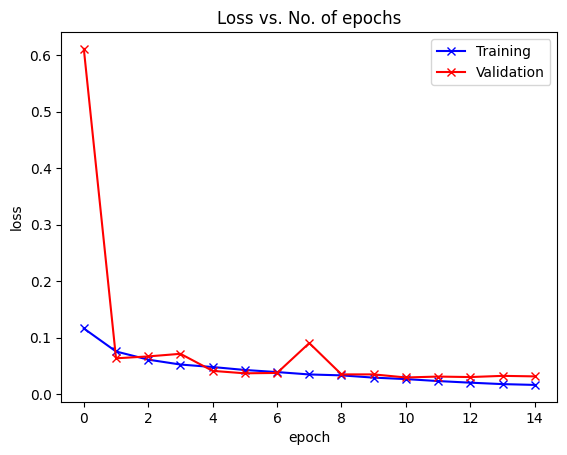

In [ ]:
plot_losses(history)

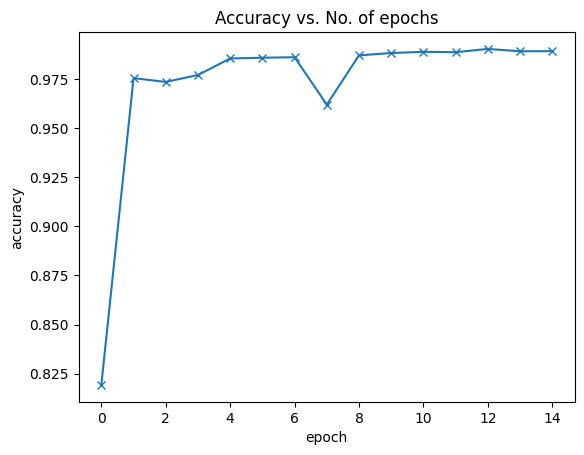

In [ ]:
plot_accuracies(history)

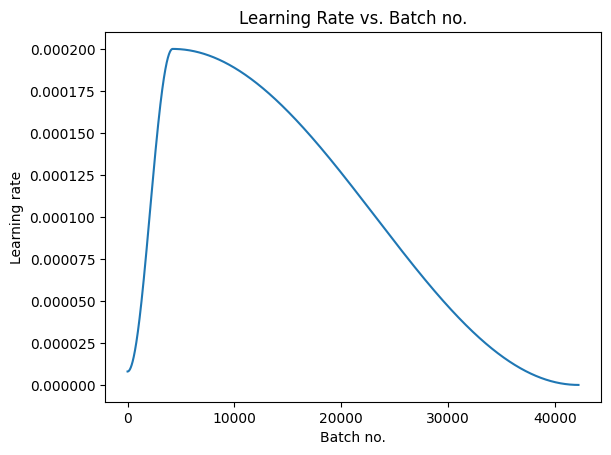

In [ ]:
plot_lrs(history)

### **`without transfer learning `**

In [ ]:
model = to_device(ResNet18(len(classes), weights=None), device) # Here we have transfer learning

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.930166244506836, 'val_acc': 0.16671109199523926}]

In [ ]:
epochs = 15
max_lr = 0.0002 # 0.0002 was good
grad_clip = 0.2
weight_decay = 1e-4
opt_func = torch.optim.Adam
history=[]

In [ ]:
%%time
history += fit_one_cycle(epochs,
                         max_lr,
                         model,
                         train_dl,
                         valid_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

Epoch [1], last_lr: 0.00015, train_loss: 0.2422, val_loss: 15.4147, val_acc: 0.2623
Model saved at epoch 1 with validation accuracy: 0.2623


Epoch [2], last_lr: 0.00020, train_loss: 0.1759, val_loss: 34.3835, val_acc: 0.2934
Model saved at epoch 2 with validation accuracy: 0.2934


Epoch [3], last_lr: 0.00019, train_loss: 0.1271, val_loss: 3.5047, val_acc: 0.4095
Model saved at epoch 3 with validation accuracy: 0.4095


Epoch [4], last_lr: 0.00018, train_loss: 0.0955, val_loss: 6.6647, val_acc: 0.2316


Epoch [5], last_lr: 0.00017, train_loss: 0.0801, val_loss: 10.1998, val_acc: 0.1835


Epoch [6], last_lr: 0.00015, train_loss: 0.0697, val_loss: 4.0182, val_acc: 0.4499
Model saved at epoch 6 with validation accuracy: 0.4499


Epoch [7], last_lr: 0.00013, train_loss: 0.0608, val_loss: 3.1630, val_acc: 0.6596
Model saved at epoch 7 with validation accuracy: 0.6596


Epoch [8], last_lr: 0.00011, train_loss: 0.0532, val_loss: 5.2722, val_acc: 0.5828


Epoch [9], last_lr: 0.00008, train_loss: 0.0490, val_loss: 0.3082, val_acc: 0.9351
Model saved at epoch 9 with validation accuracy: 0.9351


Epoch [10], last_lr: 0.00006, train_loss: 0.0452, val_loss: 1.1663, val_acc: 0.7993


Epoch [11], last_lr: 0.00004, train_loss: 0.0397, val_loss: 0.0537, val_acc: 0.9797
Model saved at epoch 11 with validation accuracy: 0.9797


Epoch [12], last_lr: 0.00002, train_loss: 0.0387, val_loss: 0.3268, val_acc: 0.8618


Epoch [13], last_lr: 0.00001, train_loss: 0.0350, val_loss: 0.0339, val_acc: 0.9873
Model saved at epoch 13 with validation accuracy: 0.9873


Epoch [14], last_lr: 0.00000, train_loss: 0.0328, val_loss: 0.0316, val_acc: 0.9885
Model saved at epoch 14 with validation accuracy: 0.9885


Epoch [15], last_lr: 0.00000, train_loss: 0.0316, val_loss: 0.0305, val_acc: 0.9889
Model saved at epoch 15 with validation accuracy: 0.9889
CPU times: user 14min 50s, sys: 2min 28s, total: 17min 19s
Wall time: 1h 19min 20s


In [ ]:
evaluate(model, test_dl)

{'val_loss': 0.03296113759279251, 'val_acc': 0.9874733686447144}

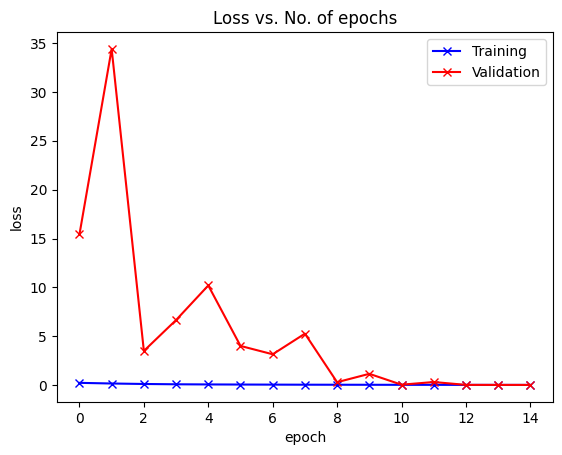

In [ ]:
plot_losses(history)

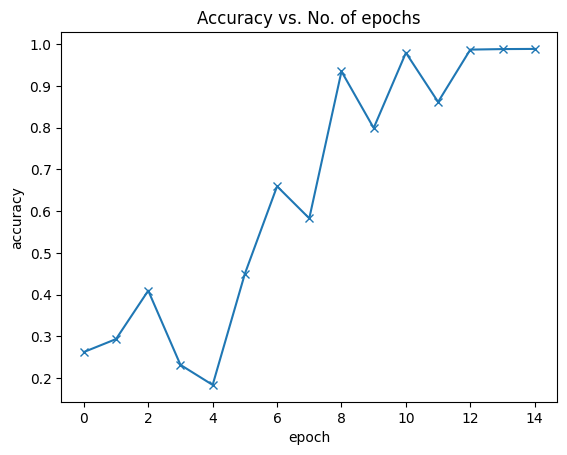

In [ ]:
plot_accuracies(history)

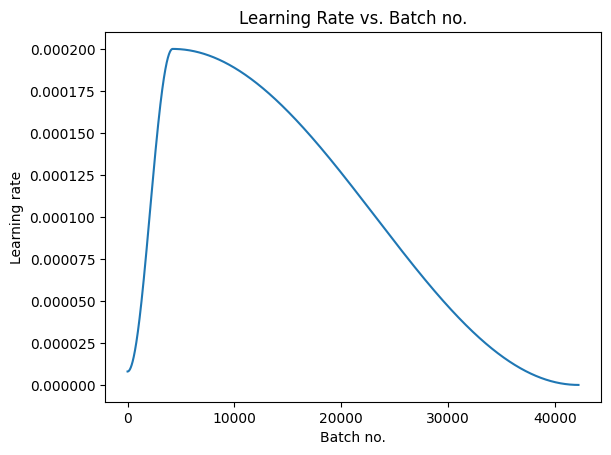

In [ ]:
plot_lrs(history)